# Are categorical variables getting lost in your random forests?

In [18]:
__author__ = 'Nick Dingwall, Chris Potts'

__TL;DR__ Decision tree models can handle categorical variables without one-hot encoding them. However, popular implementations of decision trees (and random forests) differ as to whether they honor this fact. We show that one-hot encoding can seriously degrade tree-model performance. Our primary comparison is between H2O (which honors categorical variables) and scikit-learn (which requires them to be one-hot encoded).

## Unnecessary one-hot encoding

Many real-world datasets include a mix of continuous and categorical variables. The defining property of the latter is that they do not permit a total ordering. A major advantage of __decision tree models__ and their ensemble counterparts, __random forests__, is that they are able to operate on both continuous and categorical variables directly. In contrast, most other popular models (e.g., generalized linear models, neural networks) must instead transform categorical variables into some numerical analog, usually by [one-hot encoding](http://fastml.com/converting-categorical-data-into-numbers-with-pandas-and-scikit-learn/) them to create a new __dummy variable__ for each __level__ of the original variable:

$$
    \begin{array}{c}
    \hline
    \textbf{Speciality} \\
    \hline
    \textrm{Cardiology} \\
    \textrm{Neurology} \\
    \textrm{Neurology} \\
    \textrm{Cardiology} \\
    \textrm{Gerontology} \\
    \hline
    \end{array}
    \Longrightarrow
    \begin{array}{c c c}
    \hline
    \textbf{Speciality:Cardiology} & \textbf{Specialty:Neurology} & \textbf{Specialty:Gerontology} \\
    \hline
    1 & 0 & 0 \\
    0 & 1 & 0 \\
    0 & 1 & 0 \\
    1 & 0 & 0 \\
    0 & 0 & 1 \\
    \hline
    \end{array}
$$

One-hot encoding can lead to a huge increase in the dimensionality of the feature representations. For example, one-hot encoding U.S. states adds 49 dimensions to the intuitive feature representation. In addition, one-hot encoding erases important structure in the underlying representation by splitting a single feature into many separate ones. (The naming convention used above, and by many software packages, can be misleading: the three features on the right are completely separate.)

But one-hot encoding also presents two problems that are more particular to tree-based models:

0. The resulting sparsity virtually ensures that continuous variables are assigned higher feature importance.
0. A single level of a categorical variable must meet a very high bar in order to be selected for splitting early in the tree building. This can degrade predictive performance.

This post substantiates both of these points with a comparison between [scikit-learn](http://scikit-learn.org/), which presupposes one-hot encoding, and [H2O](http://www.h2o.ai), which does not. We'll do it by constructing an artificial dataset with a known relationship between the features and the target, and explain how these problems arise.

For the most part, this post reports just our technique and central findings, but all of the code is available in [`tree_categorical_variables.py`](https://github.com/roaminsight/roamresearch/blob/master/BlogPosts/Categorical_variables_in_tree_models/tree_categorical_variables.py).

In [2]:
from tree_categorical_variables import *

## Artificial dataset

For our artificial data experiments, we define a categorical variable $c$ which takes values from $C^+$ or $C^-$ and a normally-distributed continuous variable $z \sim N(10, 3^2)$, and specify that 

$$
y = 
\begin{cases}
    1, & \text{if } c\in C^+ \text{ or } z>10 \\
    0, & \text{otherwise }
\end{cases}
$$

To make this more challenging, we'll create some further continuous variables $x_i$ that have varying correlations with $y$. 

Let's generate a dataset with $|C^+| = |C^-| = 100$, $100$ additional weakly correlated features, and $10,000$ samples:

In [3]:
data_categorical, data_onehot = generate_dataset(
    num_x=100, n_samples=10000, n_levels=200)

This produces categorical and one-hot-encoded versions of the dataset. Here's a look at the categorical version:

In [4]:
data_categorical.head(10).round(3)

,y,c,z,x0,x1,x2,x3,x4,x5,x6,...,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99
0,0,Bcj,5.096,20.839,5.857,11.273,9.136,-13.522,-7.547,6.688,...,-9.197,-19.235,-17.170,17.209,20.078,-1.486,1.250,-4.526,6.021,5.074
1,0,Bdd,5.457,-4.106,-16.195,-1.291,-3.142,-5.945,-13.608,16.278,...,2.467,-12.019,-3.356,4.469,-7.281,3.676,17.388,-15.972,5.312,-9.736
2,1,Acm,7.446,-10.008,8.149,9.797,3.698,-5.391,12.847,-4.788,...,16.849,-3.512,-9.723,-0.804,6.244,-1.250,-3.846,-6.713,-16.591,-13.154
3,1,Bav,14.722,2.954,-0.627,6.170,0.805,6.920,4.777,-19.196,...,-13.936,9.668,-9.676,-15.207,3.557,21.924,-9.538,2.439,1.360,13.622
4,1,Aau,9.487,9.774,12.963,6.013,10.483,-0.183,-1.274,-0.192,...,-4.703,-8.349,-6.488,-4.568,-6.220,8.504,21.077,19.595,5.647,-1.891
5,0,Bda,7.008,3.703,10.945,-0.883,9.745,11.052,2.947,-4.331,...,-6.177,2.523,6.759,4.919,1.389,-4.807,-18.482,-16.943,-7.114,-2.273
6,1,Abc,22.591,-4.441,1.458,6.287,10.522,9.813,12.007,3.204,...,11.854,-5.604,-2.626,6.634,-6.606,13.211,-7.424,7.848,11.435,5.171
7,0,Bal,4.906,2.439,4.332,-3.144,6.380,-7.628,0.982,8.910,...,-11.649,-2.897,13.178,-0.903,15.739,-3.357,0.492,11.231,-13.757,-4.009
8,0,Bdm,4.259,10.137,3.873,9.106,22.124,11.645,3.282,5.401,...,3.081,-1.717,-4.309,-24.010,3.920,11.018,-5.108,3.228,-4.618,-7.325
9,1,Aaa,8.091,-0.845,-8.261,4.367,-8.011,13.679,-4.163,-9.803,...,-8.021,3.241,-11.445,-2.240,4.187,4.750,-8.376,-12.305,3.217,-18.127


You'll notice that $y=1$ whenever either $c$ starts with A or $z>10$. A simple decision tree should be able to perfectly predict the outcome variable by splitting first on $c$ and then on $z$, as illustrated on the left in the following diagram:

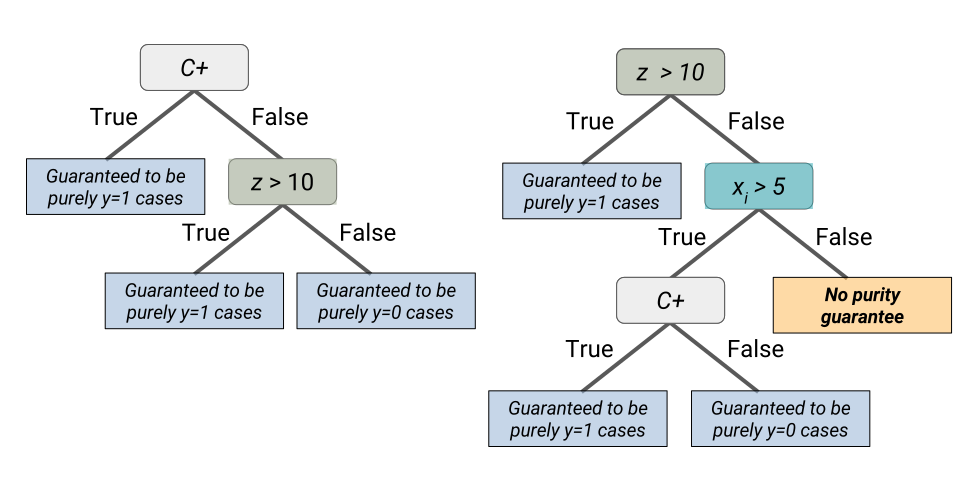

In [6]:
from IPython.display import SVG, display

display(SVG("fig/Decision tree visualization.svg"))

On the left, the $x_{i}$ variables have no contribution to make. Their noisy quality is not disruptive. On the right, however, $x_{i}$  was chosen too early. Individually, these features can be highly informative, but they do not guarantee purity, so choosing them too early can result in branches that remain impure.

Here's the top of the one-hot-encoded version; you can see all the new  variables derived from $c$ tacked on as the final set of sparse columns.

In [7]:
data_onehot.head(10).round(3)

,y,z,x0,x1,x2,x3,x4,x5,x6,x7,...,c_Bdm,c_Bdn,c_Bdo,c_Bdp,c_Bdq,c_Bdr,c_Bds,c_Bdt,c_Bdu,c_Bdv
0,0,5.096,20.839,5.857,11.273,9.136,-13.522,-7.547,6.688,-3.424,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,5.457,-4.106,-16.195,-1.291,-3.142,-5.945,-13.608,16.278,12.944,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,7.446,-10.008,8.149,9.797,3.698,-5.391,12.847,-4.788,-4.887,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,14.722,2.954,-0.627,6.170,0.805,6.920,4.777,-19.196,-0.974,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,9.487,9.774,12.963,6.013,10.483,-0.183,-1.274,-0.192,-3.102,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0,7.008,3.703,10.945,-0.883,9.745,11.052,2.947,-4.331,-4.505,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1,22.591,-4.441,1.458,6.287,10.522,9.813,12.007,3.204,4.079,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0,4.906,2.439,4.332,-3.144,6.380,-7.628,0.982,8.910,-2.757,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0,4.259,10.137,3.873,9.106,22.124,11.645,3.282,5.401,-5.530,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1,8.091,-0.845,-8.261,4.367,-8.011,13.679,-4.163,-9.803,6.423,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Could a dataset like this arise is practice? Well, perhaps knowing that somebody comes from some subset of states is enough to give good confidence of a positive outcome, but in the remaining states, we would need to consider the value of some second variable. This is the sort of basic relationship encoded in the artificial dataset.

## Artificial data bake-off

We'll first focus our discussion on single decision trees to keep things simple, and then extend the results to random forests. We conduct two kinds of analysis:

0. A baseline model that doesn't include the categorical variable $c$.

0. A model that includes $c$.

This allows us to intuitively quantify the value of $c$ for the prediction problem. For each experiment, we'll train and evaluate a tree 10 times and average the results.

### Scikit-learn's DecisionTreeClassifier

Scikit-learn can process only the one-hot-encoded version. Here's the baseline evaluation without $c$:

In [4]:
results_no_c = evaluate_sklearn_model(
    data_onehot, 
    feature_names=get_feature_names(data_onehot, include_c=False),
    target_col='y',
    model=DecisionTreeClassifier())

print_auc_mean_std(results_no_c)

AUC: mean 0.7409, sd 0.0073


The performance metric is [__area under the ROC curve__](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) (AUC) which balances the true positive and false positive rates and has a maximum value of 1.0 (perfect classification). A score of 0.73 is respectable but far from stellar. Now let's add $c$ back:

In [5]:
results_with_c = evaluate_sklearn_model(
    data_onehot, 
    feature_names=get_feature_names(data_onehot, include_c=True),
    target_col='y',
    model=DecisionTreeClassifier())

print_auc_mean_std(results_with_c)

AUC: mean 0.7558, sd 0.0104


The extra feature led to a modest improvement in AUC, although nowhere near the perfect performance that we were expecting. In addition, none of the $c$-based variables are among the top features as ranked by Gini feature importance:

In [6]:
print_sorted_mean_importances(results_with_c)

                   z: 0.341
                 x28: 0.037
                  x9: 0.033
                 x24: 0.027
                 x71: 0.016


In fact, all of the $x$-based ones have higher importance than all of the $c$-based ones.

### H2O's decision trees

H2O doesn't have a basic decision tree, but rather only random forests. To facilitate a direct comparison with scikit-learn, we wrote a little wrapper class called `H2ODecisionTree`, which specifies a single-tree forest using all the available features, which is equivalent to a single decision tree. As before, we first evaluate the model without $c$:

In [7]:
h2o_results_no_c = evaluate_h2o_model(
    data_categorical, 
    feature_names=get_feature_names(data_categorical, include_c=False),
    target_col='y', 
    model=H2ODecisionTree())

print_auc_mean_std(h2o_results_no_c)

AUC: mean 0.7326, sd 0.0075


Without $c$, the performance is very similar to scikit-learn's. But when H2O has access to $c$, it achieves an almost-perfect AUC:

In [8]:
h2o_results_with_c = evaluate_h2o_model(
    data_categorical, 
    feature_names=get_feature_names(data_categorical, include_c=True),
    target_col='y',
    model=H2ODecisionTree())

print_auc_mean_std(h2o_results_with_c)

AUC: mean 0.9990, sd 0.0007


In stark contrast to the scikit-learn models, the variable $c$ has the largest feature importance, just as our data-generation procedure leads us to expect:

In [9]:
print_sorted_mean_importances(h2o_results_with_c)

                   c: 0.701
                   z: 0.299
                 x53: 0.000
                 x88: 0.000
                 x36: 0.000


Finally, let's see what happens if we use H2O with the one-hot encoded data:

In [12]:
h2o_results_with_c_onehot = evaluate_h2o_model(
    data_onehot, 
    feature_names=get_feature_names(data_onehot, include_c=True), 
    target_col='y', 
    model=H2ODecisionTree())

print_auc_mean_std(h2o_results_with_c_onehot)

AUC: mean 0.7305, sd 0.0069


With one-hot encoding, H2O's performance is about the same as that of scikit-learn.

## What's the difference?

To understand what's causing the difference, we need to study the logic of tree-building algorithms.

### The tree building algorithm

At the heart of the tree-building algorithm is a subalgorithm that splits the samples into two bins by selecting a variable and a value. This splitting algorithm considers each of the features in turn, and for each feature selects the value of that feature that minimizes the _impurity_ of the bins. We won't get into the details of how this is calculated (and there's more than one way), except to say that you can consider a bin that contains mostly positive or mostly negative samples more pure than one that contains a mixture. There's a nice visualization of the algorithm in the [Visual Introduction to Machine Learning](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/).

In our case, we'd hope that, when the algorithm considers $z$, it would choose to split at $10$. That is, any example whose value of $z$ is less than $10$ goes to into one bin, and any whose value is greater than $10$ goes in the other. It should, in turn, further subdivide the samples assigned to the 'less-than' bin, since we know that some of these are in fact positive.

Binary variables are automatically disadvantaged here, since there is only one way to split the samples: 0s one way, and 1s the other. Low-cardinality categorical variables suffer from the same problem. Another way to look at it: a continuous variable induces an ordering of the samples, and the algorithm can split that ordered list anywhere. A binary variable can only be split in one place, and a categorical variable with $q$ levels can be split in $\frac{2^{q}}{2} - 1$ ways.

An important sidenote: we don't actually have to search all the partitions because there are efficient algorithms for both binary classification and regression that are guaranteed to find the optimal split in linear time &mdash; see page 310 of the [Elements of Statistical Learning](http://statweb.stanford.edu/~tibs/ElemStatLearn/). No such guarantee exists for multinomial classification, but there is a [heuristic](http://link.springer.com/article/10.1023/A%3A1009869804967?no-access=true).

### Why one-hot encoding is bad bad bad for trees

#### Predictive Performance

By one-hot encoding a categorical variable, we create many binary variables, and from the splitting algorithm's point of view, they're all independent. This means a categorical variable is already disadvantaged over continuous variables. But there's a further problem: these binary variables are _sparse_. Imagine our categorical variable has 100 levels, each appearing about as often as the others. The best the algorithm can expect to do by splitting on one of its one-hot encoded dummies is to reduce impurity by $\approx 1\%$, since each of the dummies will be 'hot' for around $1\%$ of the samples.

The result of all this is that, if we start by one-hot encoding a high-cardinality variable, the tree building algorithm is unlikely to select one of its dummies as the splitting variable near the root of the tree, instead choosing continuous variables. In datasets like the one we created here, that leads to inferior performance.

In contrast, by considering all of the levels of $c$ at once, H2O's algorithm is able to select $c$ at the very top of the tree.

#### Interpretability

The importance score assigned to each feature is a measure of how often that feature was selected, and how much of an effect it had in reducing impurity when it was selected. (We don't consider [permutation feature importance](http://blog.datadive.net/selecting-good-features-part-iii-random-forests/) here; this might help combat the preference for continuous variables over binary ones, but it will not help with the induced sparsity.)

H2O assigns about $70\%$ of its importance to $c$, and the remaining $30\%$ to $z$. Scikit-learn, in contrast, assigns less than $10\%$ in total to the one-hot encodings of $c$, $30\%$ to $z$ and almost $60\%$ collectively to $x_i$, features that are entirely unnecessarily to perfectly classify the data!

### Fewer levels, fewer problems

As we discussed, this problem is especially profound for high-cardinality categorical variables. If the categorical variables have few levels, then the induced sparsity is less severe and the one-hot encoded versions have a chance of competing with the continuous ones.

## Ensembles and other models

Random forests are simply ensembles of trees where each individual tree is built using a subset of both features and samples. So we'd expect a similar reduction in performance in the scikit-learn ensembles compared to the H2O ensembles. To test this, we train random forest ensembles with 100 trees using each implementation. The difference is once again dramatic:

In [14]:
sklearn_ensemble_results = evaluate_sklearn_model(
    data_onehot,
    feature_names=get_feature_names(data_onehot, include_c=True),
    target_col='y',
    model=RandomForestClassifier(n_estimators=100))

print_auc_mean_std(sklearn_ensemble_results)

AUC: mean 0.9215, sd 0.0038


In [15]:
h2o_ensemble_results = evaluate_h2o_model(
    data_categorical, 
    feature_names=get_feature_names(data_categorical, include_c=True),
    target_col='y',
    model=H2ORandomForestEstimator(ntrees=100))

print_auc_mean_std(h2o_ensemble_results)

AUC: mean 1.0000, sd 0.0000


Let's also test a scikit-learn `LogisticRegressionCV` classifier, to compare a linear classifier with the tree-based ones:

In [16]:
sklearn_regression_results = evaluate_sklearn_model(
    data_onehot, 
    feature_names=get_feature_names(data_onehot, include_c=True),
    target_col='y',
    model=LogisticRegressionCV())

print_auc_mean_std(sklearn_regression_results)

AUC: mean 0.9971, sd 0.0006


When we use the one-hot encoded features, logistic regression produces a much better classifier than a scikit-learn random forest. This shouldn't be surprising: linear classifers can perfectly capture `OR` relations, and the features $x_i$ are all normally-distributed and contribute to a Bernoulli sampling probability for $y.$

## A note about R

We trained a model on the same data using R's `rpart` and that achieved near-perfect performance when $c$ was included, and similar performance to scikit-learn and H2O without it. It seems to be correctly treating $c$ as a single categorical variable.

However, R's `randomForest` package only allows up to 53 levels per categorical variable (this has recently increased from 32) and even then, it gets very slow as the number of levels increases. It's hard to know why this should be the case for binary classification or regression, since efficient algorithms exist to find the optimal partition, but it seems like it is performing a somewhat-exhaustive search of partitions of $c$. Please send us a message if you have any insight!

## Moving on...

So, what can be done? There is some discussion about incorporating [support for categorical features](https://github.com/scikit-learn/scikit-learn/pull/3346) in scikit-learn, but that seems to be a way off. In the meantime, perhaps consider using [H2O](http://www.h2o.ai/product/python/).  Whatever you do, at least be aware that, despite theoretical results suggesting the expressive power of random forests with one-hot encoded features is the same as for categorical variables, the practical results are very different!